# XGBoost Regression

In [1]:
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import numpy as np

from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

import xgboost as xgb

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('FE_data_18-19.csv', index_col=0)

# sort by date
df.sort_values(by='Date', inplace=True)

# make date the index
df.set_index('Date',inplace=True)

In [3]:
# split off end of 2019 as test set
test_size = df.shape[0] - 30
train, test = df.iloc[:test_size], df.iloc[test_size:]

# encode location
le = LabelEncoder()
le.fit(train['Location'])
train['Location'] = le.transform(train['Location'])
test['Location'] = le.transform(test['Location'])

X_train, X_test = train.drop(labels=['SsMean','logSsMean'], axis=1), test.drop(labels=['SsMean','logSsMean'], axis=1)
y_train, y_test = train.logSsMean, test.logSsMean

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

xg = xgb.XGBRegressor()
xg.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


[15:43:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

Training acc: 0.7696139280159534
Testing acc: 0.2207235452515397
Mean squared error:  2.5856022814933466
MAE:  1.2308400383398868


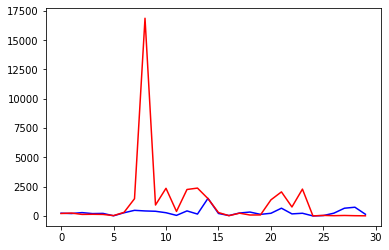

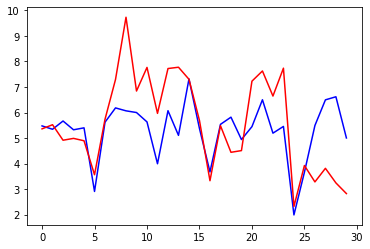

In [4]:
y_pred = xg.predict(X_test)
train_score = xg.score(X_train, y_train.values)
score = xg.score(X_test, y_test.values)
print('Training acc:', train_score)
print('Testing acc:', score)
train_pred = xg.predict(X_train)

mse = mean_squared_error(y_test, y_pred)
print('Mean squared error: ', mse)
mae = mean_absolute_error(y_test, y_pred)
print('MAE: ', mae)

plt.plot(np.exp(y_pred), c='b')
plt.plot(np.exp(y_test.values), c='r')
plt.show()

plt.plot(y_pred, c='b')
plt.plot(y_test.values, c='r')
plt.show()

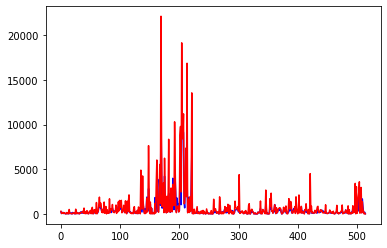

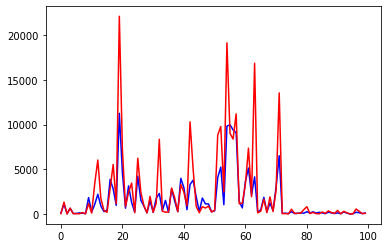

In [5]:
# plot training
plt.plot(np.exp(train_pred), c='b')
plt.plot(np.exp(y_train.values), c='r')
plt.show()

# close up
plt.plot(np.exp(train_pred)[150:250], c='b')
plt.plot(np.exp(y_train.values)[150:250], c='r')
plt.show()

In [6]:
def classify(data):
    if data < 60:
        return 0
    elif data < 250:
        return 1
    elif data < 500:
        return 2
    elif data >= 500:
        return 3
    
def from_log(data):
    return np.exp(data)

In [7]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [8]:
test_result = pd.DataFrame()
test_result['log_y_pred'] = y_pred
test_result['y_pred'] = test_result.log_y_pred.apply(from_log)
test_result['pred_label'] = test_result.y_pred.apply(classify)
test_result['y'] = y_test.values
test_result['y_log'] = test_result.y.apply(from_log)
test_result['true_label'] = test_result.y_log.apply(classify)

In [9]:
cr = classification_report(test_result.true_label, test_result.pred_label)
print(cr)

              precision    recall  f1-score   support

           0       0.80      0.50      0.62         8
           1       0.33      0.57      0.42         7
           2       0.11      0.25      0.15         4
           3       0.50      0.18      0.27        11

    accuracy                           0.37        30
   macro avg       0.44      0.38      0.36        30
weighted avg       0.49      0.37      0.38        30



Confusion matrix, without normalization
[[4 2 0 2]
 [0 4 3 0]
 [1 2 1 0]
 [0 4 5 2]]


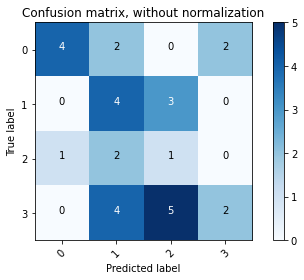

In [10]:
cm = confusion_matrix(test_result.true_label, test_result.pred_label)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=[0,1,2,3],
                      title='Confusion matrix, without normalization')

### Cross val grid search

In [36]:
from sklearn.model_selection import GridSearchCV

params = {
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [3, 2],
    'reg_alpha': [1, 2, 3],
    'reg_lambda': [1,2,3],
    'gamma': [0,1,2,3],
    'n_estimators': [100, 200],
    'objective': ['reg:squarederror']
}

kfolds = 5

clf = GridSearchCV(estimator=xgb.XGBRegressor(), param_grid=params, cv=kfolds, verbose=1)

In [37]:
# split off end of 2019 as test set
test_size = df.shape[0] - 30
train, test = df.iloc[:test_size], df.iloc[test_size:]

# encode location
le = LabelEncoder()
le.fit(train['Location'])
train['Location'] = le.transform(train['Location'])
test['Location'] = le.transform(test['Location'])

X_train, X_test = train.drop(labels=['SsMean','logSsMean'], axis=1), test.drop(labels=['SsMean','logSsMean'], axis=1)
y_train, y_test = train.logSsMean, test.logSsMean

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [38]:
clf.fit(X_train,y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2160 out of 2160 | elapsed:  4.4min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_...
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'gamma': [0, 1, 2, 3],
                         'learning_rate': [0.1, 0.05, 0.01],
                         'max

In [39]:
best_parameters = clf.best_params_
print(best_parameters)

{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100, 'objective': 'reg:squarederror', 'reg_alpha': 2, 'reg_lambda': 1}


In [40]:
best_result = clf.best_score_
print(best_result)

0.18413676804891815


In [41]:
model = clf.best_estimator_

Training acc: 0.5233775958904873
Testing acc: 0.24828699260269851
Mean squared error:  2.4941480717290054
MAE:  1.2495154209678863


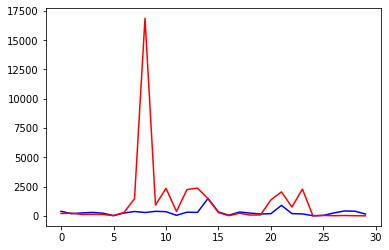

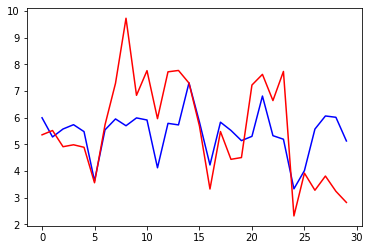

In [42]:
y_pred = model.predict(X_test)
train_score = model.score(X_train, y_train.values)
score = model.score(X_test, y_test.values)
print('Training acc:', train_score)
print('Testing acc:', score)
train_pred = model.predict(X_train)

mse = mean_squared_error(y_test, y_pred)
print('Mean squared error: ', mse)
mae = mean_absolute_error(y_test, y_pred)
print('MAE: ', mae)

plt.plot(np.exp(y_pred), c='b')
plt.plot(np.exp(y_test.values), c='r')
plt.show()

plt.plot(y_pred, c='b')
plt.plot(y_test.values, c='r')
plt.show()

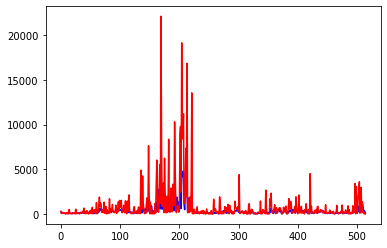

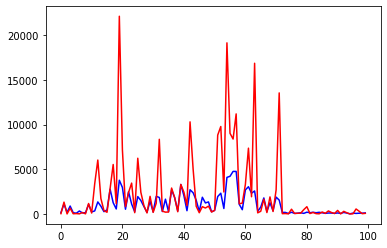

In [43]:
# plot training
plt.plot(np.exp(train_pred), c='b')
plt.plot(np.exp(y_train.values), c='r')
plt.show()

# close up
plt.plot(np.exp(train_pred)[150:250], c='b')
plt.plot(np.exp(y_train.values)[150:250], c='r')
plt.show()

In [44]:
def classify(data):
    if data < 60:
        return 0
    elif data < 250:
        return 1
    elif data < 500:
        return 2
    elif data >= 500:
        return 3
    
def from_log(data):
    return np.exp(data)

In [32]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [45]:
test_result = pd.DataFrame()
test_result['log_y_pred'] = y_pred
test_result['y_pred'] = test_result.log_y_pred.apply(from_log)
test_result['pred_label'] = test_result.y_pred.apply(classify)
test_result['y'] = y_test.values
test_result['y_log'] = test_result.y.apply(from_log)
test_result['true_label'] = test_result.y_log.apply(classify)

cr = classification_report(test_result.true_label, test_result.pred_label)
print(cr)

              precision    recall  f1-score   support

           0       1.00      0.38      0.55         8
           1       0.22      0.29      0.25         7
           2       0.12      0.50      0.20         4
           3       1.00      0.18      0.31        11

    accuracy                           0.30        30
   macro avg       0.59      0.34      0.33        30
weighted avg       0.70      0.30      0.34        30



Confusion matrix, without normalization
[[3 2 3 0]
 [0 2 5 0]
 [0 2 2 0]
 [0 3 6 2]]


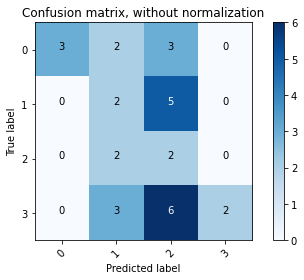

In [46]:
cm = confusion_matrix(test_result.true_label, test_result.pred_label)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=[0,1,2,3],
                      title='Confusion matrix, without normalization')